# 0) Mount drive + Load YOLO (colab)

In [1]:
# from google.colab import drive

# drive.mount('/content/drive')

In [2]:
# I somehow cant do pip install, it crash the notebook

!pip install ultralytics

!pip install python-chess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148498 sha256=5fc3fdea7c7fcf8888ccd526bcdcedcb8308880d83419fa35ad9fa40c847fa9a
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


# 1) Import things

In [3]:
from ultralytics import YOLO

import cv2

import numpy as np

import pandas as pd

import cv2

import matplotlib.pyplot as plt

import chess

import chess.pgn

from IPython.display import display, SVG

import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# 2) Define Models

In [4]:
piece_model_path = "/kaggle/input/piece-detect/pytorch/default/1/best (1).pt"

corner_model_path = "/kaggle/input/corner-detect/pytorch/default/1/corner-detect (1).pt"

In [5]:
piece_model = YOLO(piece_model_path)

corner_model = YOLO(corner_model_path)

In [6]:
print(piece_model.names)

{0: 'black-bishop', 1: 'black-king', 2: 'black-knight', 3: 'black-pawn', 4: 'black-queen', 5: 'black-rook', 6: 'white-bishop', 7: 'white-king', 8: 'white-knight', 9: 'white-pawn', 10: 'white-queen', 11: 'white-rook'}


# 3) Define **Functions**

In [7]:
def get_chessboard_corners(results):

    detections = results[0]

    boxes = detections.boxes.xyxy.cpu().numpy() if hasattr(detections.boxes.xyxy, 'cpu') else detections.boxes.xyxy

    scores = detections.boxes.conf.cpu().numpy() if hasattr(detections.boxes.conf, 'cpu') else detections.boxes.conf

    class_ids = detections.boxes.cls.cpu().numpy() if hasattr(detections.boxes.cls, 'cpu') else detections.boxes.cls



    corner_dict = {0: None, 1: None, 2: None, 3: None}



    for box, score, class_id in zip(boxes, scores, class_ids):

        if class_id in corner_dict:

            if corner_dict[class_id] is None or score > corner_dict[class_id][1]:

                x_center = (box[0] + box[2]) / 2

                y_center = (box[1] + box[3]) / 2

                corner_dict[class_id] = ((x_center, y_center), score)



    corners = []

    for class_id in [2, 3, 1, 0]:

        if corner_dict[class_id]:

            corners.append(corner_dict[class_id][0])

        else:

            corners.append((0, 0))



    return np.array(corners)

In [8]:
def get_chessboard_corners_with_paddings(corners, padding_ratio=0.065):



    corners = np.array(corners)



    center = np.mean(corners, axis=0)



    top_to_bottom = (corners[3] - corners[0] + corners[2] - corners[1]) / 2

    left_to_right = (corners[1] - corners[0] + corners[2] - corners[3]) / 2



    board_width = np.linalg.norm(left_to_right)

    board_height = np.linalg.norm(top_to_bottom)



    top_to_bottom_unit = top_to_bottom / np.linalg.norm(top_to_bottom)

    left_to_right_unit = left_to_right / np.linalg.norm(left_to_right)



    x_padding = padding_ratio * board_width

    y_padding = padding_ratio * board_height



    expanded_corners = np.zeros_like(corners)



    for i, corner in enumerate(corners):

        direction = (corner - center)

        unit_vector = direction / np.linalg.norm(direction)

        expanded_corners[i] = corner + unit_vector * (x_padding + y_padding)



    return expanded_corners

In [9]:
def get_corner(img, corner_model_path):



    corner_model = YOLO(corner_model_path)

    corner_points = corner_model.predict(source=img, conf=0.01, save=False, verbose=False)



    return get_chessboard_corners(corner_points)



def find_pieces(img, piece_model_path):



    piece_model = YOLO(piece_model_path)

    results = piece_model.predict(source=img, conf=0.1, save=False, verbose=False)



    return results

In [10]:
def four_point_transform(image, rect):



    image = np.asarray(image)

    (tl, tr, br, bl) = rect



    if (tl[0]==0 and tl[1]==0) or (tr[0]==0 and tr[1]==0) or (br[0]==0 and br[1]==0) or (bl[0]==0 and bl[1]==0):

        return image, None



    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))

    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

    maxWidth = max(int(widthA), int(widthB))



    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))

    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

    maxHeight = max(int(heightA), int(heightB))



    dst = np.array([

        [0, 0],

        [maxWidth - 1, 0],

        [maxWidth - 1, maxHeight - 1],

        [0, maxHeight - 1]], dtype="float32")



    M = cv2.getPerspectiveTransform(rect, dst)

    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))



    return warped, M

In [11]:
def get_square_centers(transformed_image, corner2):

    height = abs(corner2[2][1] - corner2[0][1])

    width = abs(corner2[3][0] - corner2[1][0])



    ranks = range(1, 9)

    files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

    square_centers = {}

    for rank in ranks:

        for file_index, file in enumerate(files):

            x_center = file_index * width // 8 + width // 16 + corner2[0][0]

            y_center = (8 - rank) * height // 8 + height // 16 + corner2[0][1]

            square_centers[(rank, file)] = (x_center, y_center)

    return square_centers

In [12]:
def find_and_transform_board(img, corner_model_path):



    corner_model = YOLO(corner_model_path)

    corner_points = corner_model.predict(source=img, conf=0.2, save=False, verbose=False)

    corners = get_chessboard_corners(corner_points).astype("float32")

    corners_w_pd = get_chessboard_corners_with_paddings(corners,0.065).astype("float32")

    transformed_image_w_padding, _ = four_point_transform(img, corners_w_pd)



    return transformed_image_w_padding

In [13]:
def to_fen_notation(results, transformed_image, corner2):

    files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']



    class_to_fen = {

        0: 'b',  # Black bishop

        1: 'k',  # Black king

        2: 'n',  # Black knight

        3: 'p',  # Black pawn

        4: 'q',  # Black queen

        5: 'r',  # Black rook

        6: 'B',  # White bishop

        7: 'K',  # White king

        8: 'N',  # White knight

        9: 'P', # White pawn

        10: 'Q', # White queen

        11: 'R'  # White rook

    }



    fen_board = [['' for _ in range(8)] for _ in range(8)]

    square_centers = get_square_centers(transformed_image, corner2)



    square_to_piece = {}





    for result in results[0].boxes:



        box = result.xyxy[0]

        cls = int(result.cls[0])

        conf = float(result.conf[0])



        x1, y1, x2, y2 = box.tolist()

        cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)

        cy = int(cy - 0.1 * (y2 - y1))



        closest_square = None

        min_distance = float('inf')

        for (rank, file), (sx, sy) in square_centers.items():

            distance = np.sqrt((cx - sx)**2 + (cy - sy)**2)

            if distance < min_distance:

                min_distance = distance

                closest_square = (rank, file)



        if closest_square:

            if closest_square not in square_to_piece or conf > square_to_piece[closest_square]['conf']:

                square_to_piece[closest_square] = {'piece': class_to_fen.get(cls, '?'), 'conf': conf}



    for (rank, file), piece_data in square_to_piece.items():

        file_index = files.index(file)

        fen_board[8 - rank][file_index] = piece_data['piece']



    fen_rows = []

    for row in fen_board:

        fen_row = ''

        empty_count = 0

        for square in row:

            if square == '':

                empty_count += 1

            else:

                if empty_count > 0:

                    fen_row += str(empty_count)

                    empty_count = 0

                fen_row += square

        if empty_count > 0:

            fen_row += str(empty_count)

        fen_rows.append(fen_row)



    fen_string = '/'.join(fen_rows)



    return fen_string


In [14]:
def get_fen(img, corner_model_path, piece_model_path):



    process_img = find_and_transform_board(img, corner_model_path)

    corner_after_perspective_transform = get_corner(process_img, corner_model_path)

    process_img_with_pieces = find_pieces(process_img, piece_model_path)

    fen = to_fen_notation(process_img_with_pieces, process_img, corner_after_perspective_transform)



    return fen

In [15]:
def detect_piece_movement(initial_fen, final_fen):

    initial_position = initial_fen.split()[0] 
    final_position = final_fen.split()[0]
    initial_rows = initial_position.split('/')
    final_rows = final_position.split('/')

    from_square = None
    to_square = None

    for rank in range(8):
        initial_row = initial_rows[rank]
        final_row = final_rows[rank]
        file_index = 0  # Keeps track of the file (a, b, c, ..., h) index

        for initial_square, final_square in zip(initial_row, final_row):
            # Handle empty squares (e.g., "3" means 3 empty squares)
            if initial_square.isdigit():
                file_index += int(initial_square)
            else:
                initial_square_piece = initial_square
                file_index += 1

            if final_square.isdigit():
                file_index += int(final_square)
            else:
                final_square_piece = final_square
                file_index += 1

            if initial_square != final_square:  # A difference was found
                if initial_square != '1' and final_square == '1':  # Piece moved out of this square
                    from_square = f"{chr(ord('a') + file_index - 1)}{8 - rank}"
                elif initial_square == '1' and final_square != '1':  # Piece moved into this square
                    to_square = f"{chr(ord('a') + file_index - 1)}{8 - rank}"

    return from_square, to_square

def get_move_between_fens(initial_fen, final_fen):

    # Initialize boards for both potential sides to move
    white_board = chess.Board(initial_fen + " w - - 0 1")
    black_board = chess.Board(initial_fen + " b - - 0 1")
    final_board = chess.Board(final_fen + " w - - 0 1")  # The turn here doesn't matter for the final position

    # Check if the move was made by White
    for potential_move in white_board.legal_moves:
        test_board = white_board.copy()
        test_board.push(potential_move)
        if test_board.fen().split()[0] == final_board.fen().split()[0]:
            return True, white_board.san(potential_move)

    # Check if the move was made by Black
    for potential_move in black_board.legal_moves:
        test_board = black_board.copy()
        test_board.push(potential_move)
        if test_board.fen().split()[0] == final_board.fen().split()[0]:
            return False, black_board.san(potential_move)

    # If no move is found using legal moves, use piece movement detection
    from_square, to_square = detect_piece_movement(initial_fen, final_fen)
    if from_square and to_square:
        move_san = f"{from_square}{to_square}"
        is_white_move = from_square[1] in '1357'  # Check if the from-square is on a black rank (1, 3, 5, 7)
        return not is_white_move, move_san  # If it's not black, it's white's move

    # If no move is found, return empty result
    return None, ""

def fen_to_pgn(fen_list):

    if len(fen_list) < 2:
        return "1. d4"

    result = ""
    move_number = 1  # Tracks the PGN move number
    is_white_turn, first_move_san = get_move_between_fens(fen_list[0], fen_list[1])

    if is_white_turn is None:  # No move detected
        return "1. d4"  # Placeholder to avoid empty result

    if not is_white_turn:  # Black moves first, so start with '1...'
        result += f"{move_number}... {first_move_san} "
        move_number += 1  # Black made the move, so next is White's turn in this system
    else:
        result += f"{move_number}.{first_move_san} "

    is_white_turn = not is_white_turn  # Alternate turn after first move

    for i in range(2, len(fen_list)):  # Start from the second move since the first move was handled
        current_fen = fen_list[i - 1]
        next_fen = fen_list[i]
        is_current_white_move, move_san = get_move_between_fens(current_fen, next_fen)
        if move_san == "":  # If no move is detected, continue (shouldn't happen with valid FENs)
            continue

        if is_white_turn:  # White's turn
            result += f"{move_number}.{move_san} "
        else:  # Black's turn
            result += f"{move_san} "
            move_number += 1  # Complete one full move pair (White + Black)

        is_white_turn = not is_white_turn  # Alternate turn

    if result == "":
        result = "1.d4" # Handle unexpected error

    return result.strip()

In [16]:

def video_to_fen_list(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    last_fen = ""
    fen_list = []

    def count_pieces(fen):
        return sum(1 for char in fen if char.isalpha())

    def check_piece_change(last_fen, current_fen):
        def clean_fen(fen):
            return fen.replace('/', '').replace(' ', '')

        last_fen_cleaned = clean_fen(last_fen)
        current_fen_cleaned = clean_fen(current_fen)

        if len(last_fen_cleaned) != 64 or len(current_fen_cleaned) != 64:
            return False

        for i in range(64):
            if last_fen_cleaned[i] != current_fen_cleaned[i] and current_fen_cleaned[i].isalpha() and last_fen_cleaned[i].isalpha():
                return True
        
        return False


    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % 300 == 0:
            fen = get_fen(frame, corner_model_path, piece_model_path)

            if fen == last_fen or (count_pieces(fen) > count_pieces(last_fen) and last_fen != ""):
                frame_count += 1
                continue

            if count_pieces(last_fen) - count_pieces(fen) > 1:
                frame_count += 1
                fen = last_fen
                continue


            if check_piece_change(last_fen, fen):
                fen = last_fen

            last_fen = fen

            board = chess.Board(fen=fen)

            fen_list.append(fen)

            display(SVG(chess.svg.board(board=board, size=400)))

        frame_count += 1

    cap.release()
    return fen_list


In [17]:
def video_to_pgn(vdo_path):



    fen_list = video_to_fen_list(vdo_path)

    pgn = fen_to_pgn(fen_list)



    return pgn

# 4) Video to csv

In [18]:
def video_to_csv(video_dir, bonus_vdo_dir):
    data = []

    for video_name in os.listdir(video_dir):

        if video_name.endswith(".mp4"):
            
            video_path = os.path.join(video_dir, video_name)
            
            print(f'Processing {video_path}')
            
            pgn = video_to_pgn(video_path)
            
            data.append({"row_id": video_name, "output": pgn})

    if bonus_vdo_dir.endswith(".mp4"):
        
        print(f'Processing {bonus_vdo_dir}')
        
        bonus_pgn = video_to_pgn(bonus_vdo_dir)
        
        data.append({"row_id": os.path.basename(bonus_vdo_dir), "output": bonus_pgn})


    df = pd.DataFrame(data)
    return df

Processing /kaggle/input/chess-test/test_videos/4_Move_studet.mp4


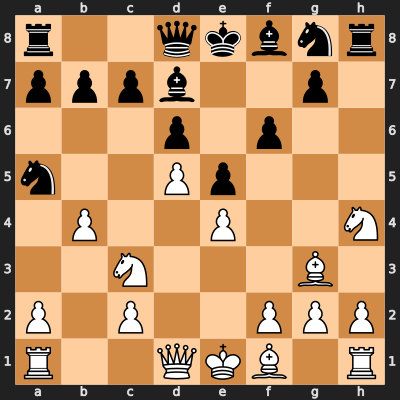

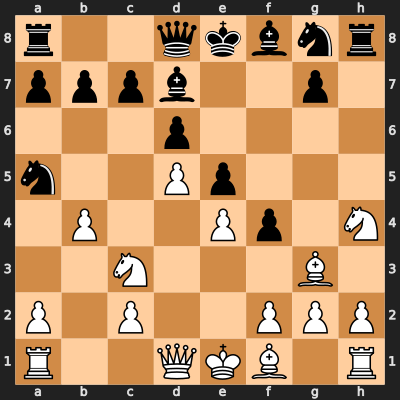

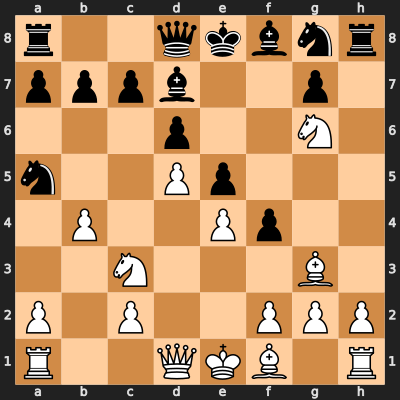

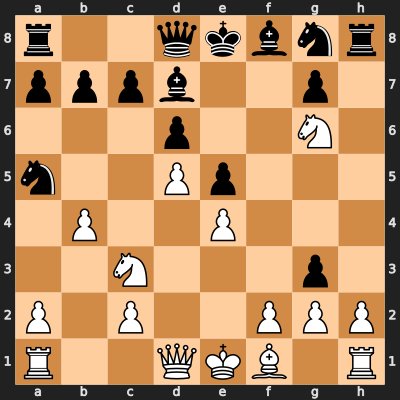

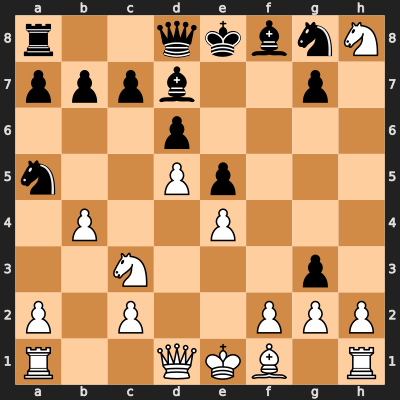

Processing /kaggle/input/chess-test/test_videos/2_Move_rotate_student.mp4


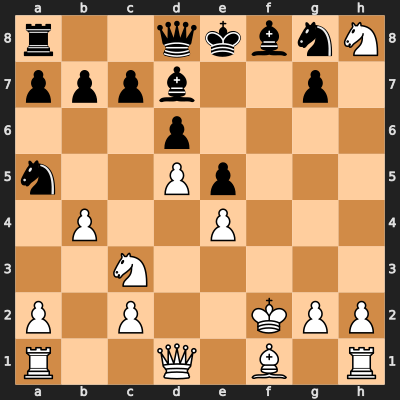

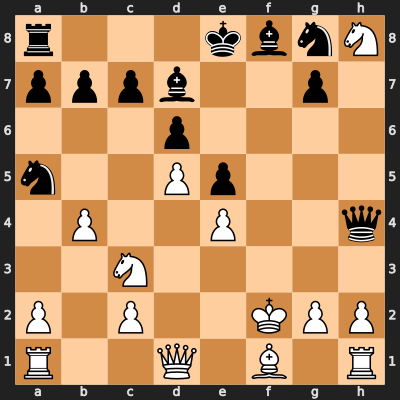

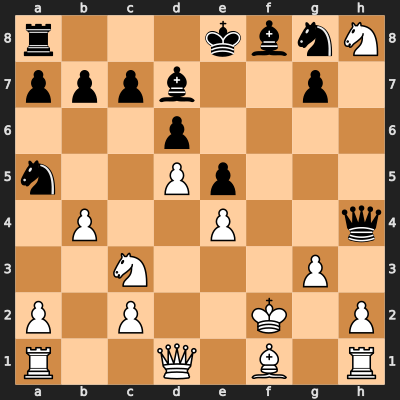

Processing /kaggle/input/chess-test/test_videos/2_move_student.mp4


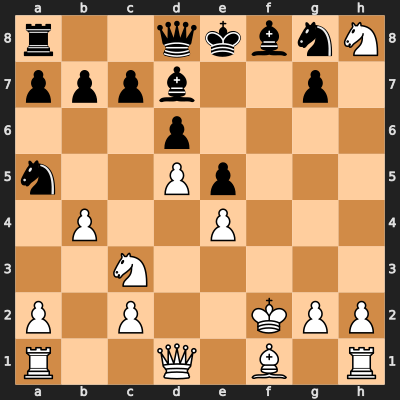

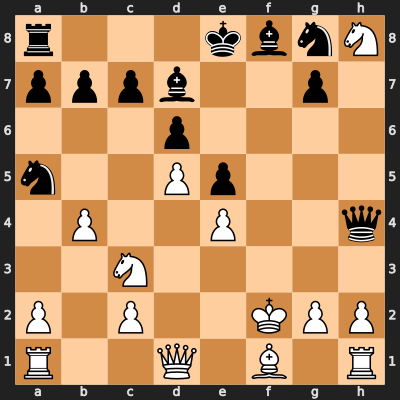

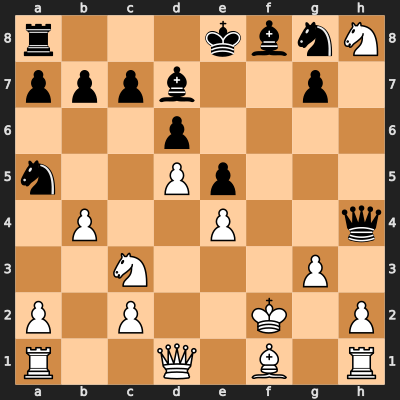

Processing /kaggle/input/chess-test/test_videos/6_Move_student.mp4


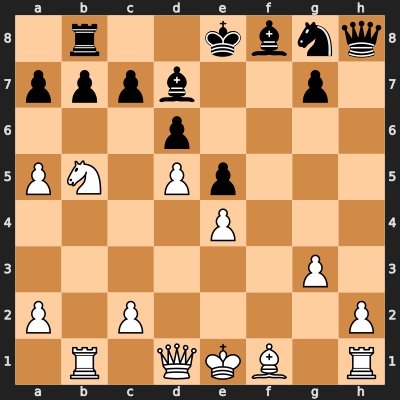

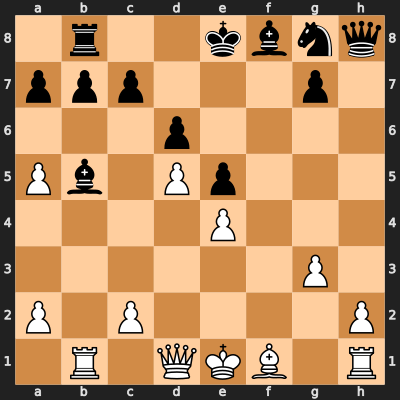

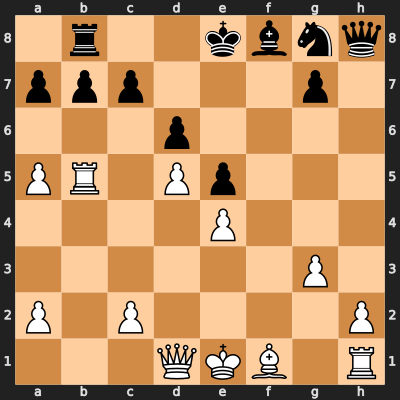

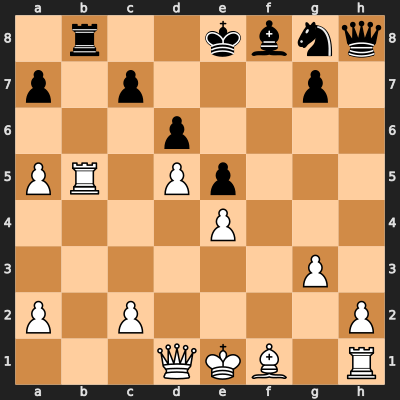

Processing /kaggle/input/chess-test/test_videos/8_Move_student.mp4


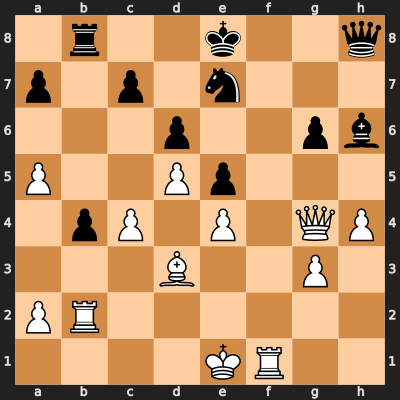

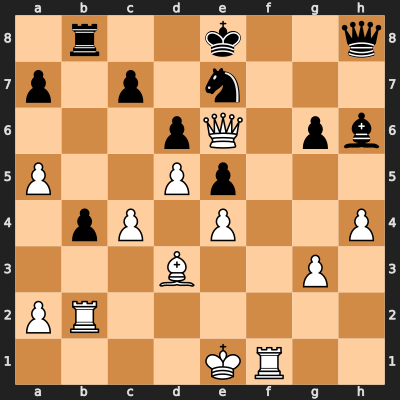

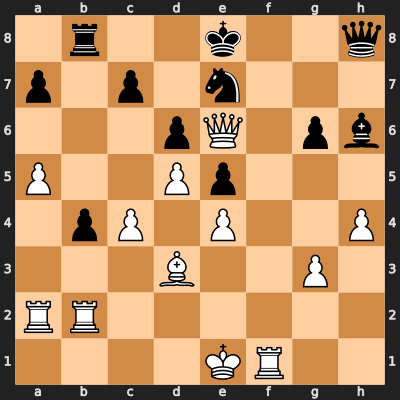

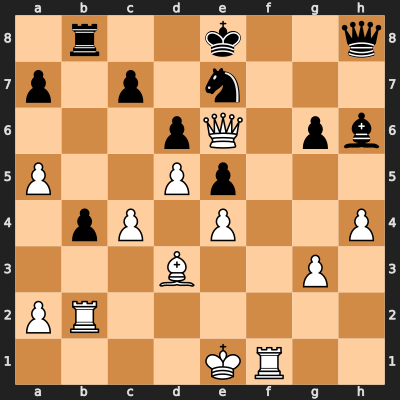

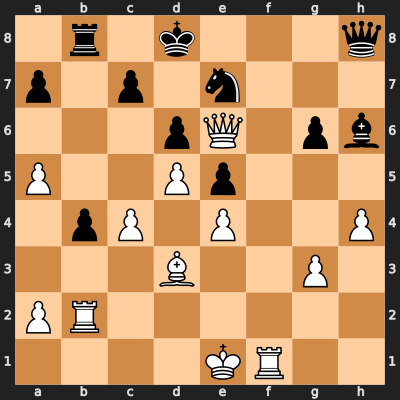

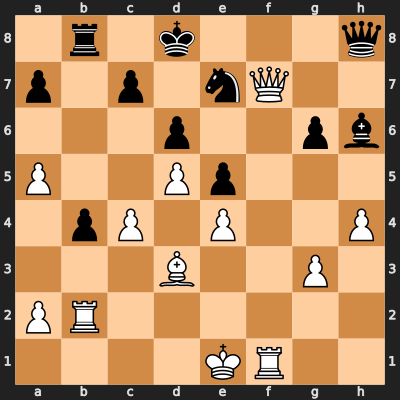

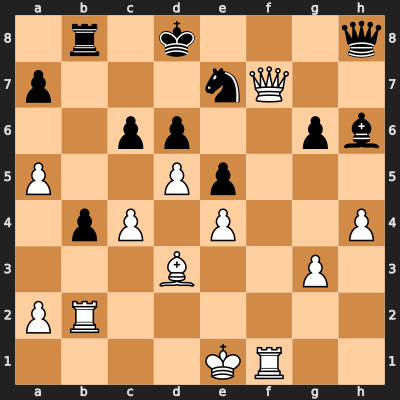

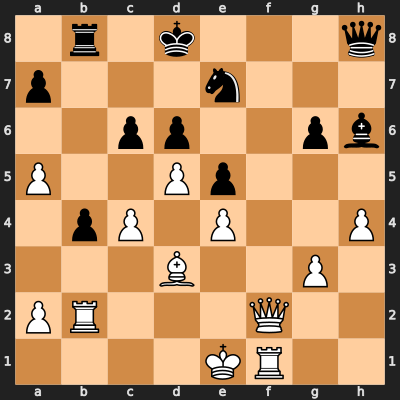

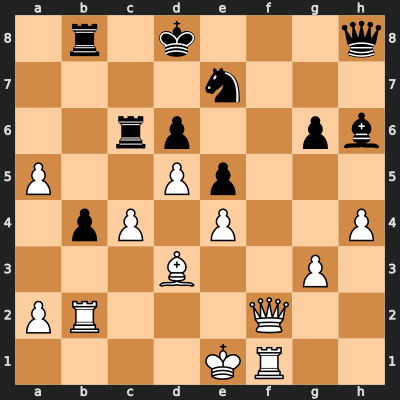

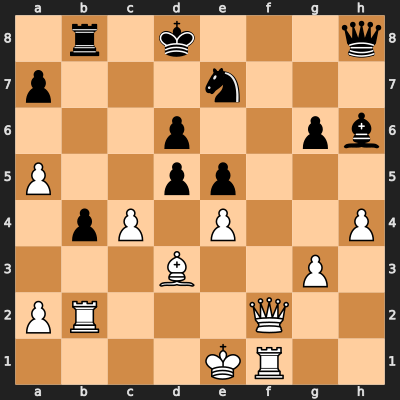

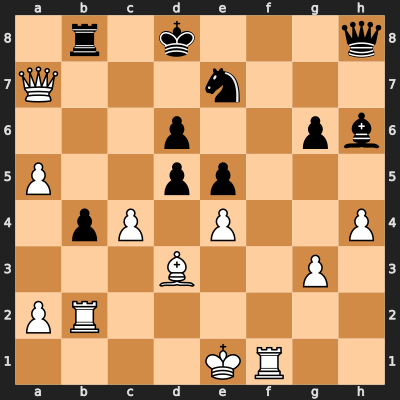

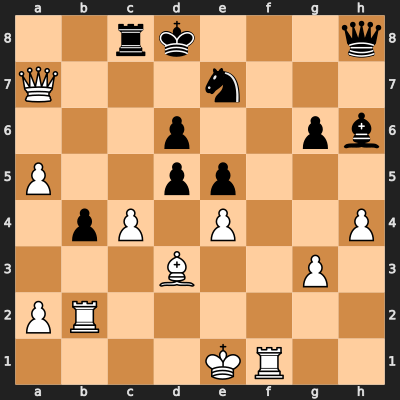

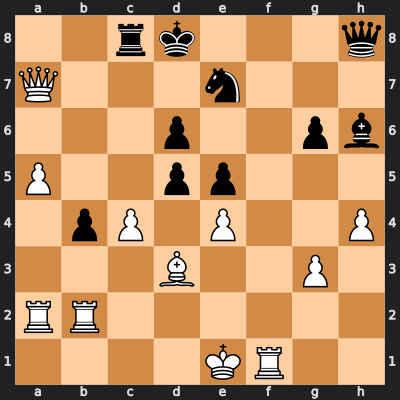

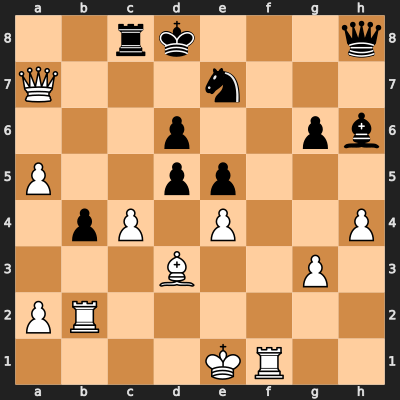

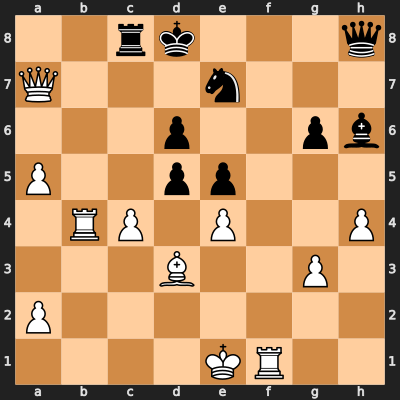

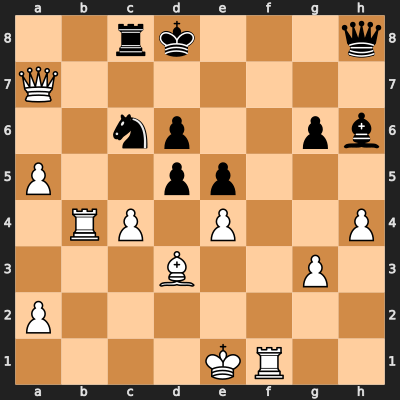

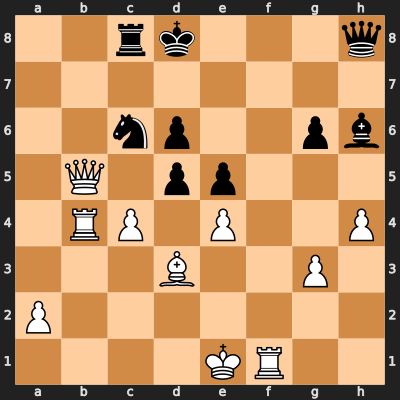

Processing /kaggle/input/bonus-video/(Bonus)Long_video_student.mp4


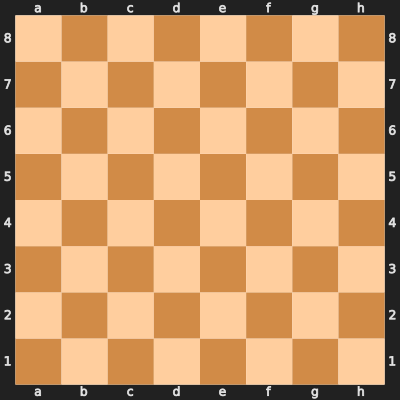

In [19]:
vdo_dir = "/kaggle/input/chess-test/test_videos"
bonus_vdo_dir = "/kaggle/input/bonus-video/(Bonus)Long_video_student.mp4"
df =  video_to_csv(vdo_dir, bonus_vdo_dir)

In [20]:
df.to_csv("submission_solution.csv", index=False, encoding="utf-8")

In [21]:
df

,row_id,output
0,4_Move_studet.mp4,1.o4m6 Ng6 2.fxg3 Nxh8
1,2_Move_rotate_student.mp4,1... Qh4+ 2.g3
2,2_move_student.mp4,1... Qh4+ 2.g3
3,6_Move_student.mp4,1... Bxb5 2.Rxb5
4,8_Move_student.mp4,1.Qe6 Kd8 2.Qf7 c6 3.Qf2 Qxa7 4.Rc8 Rxb4 5.Nc6
5,(Bonus)Long_video_student.mp4,1. d4
